This notebook is a training of a LogisticRegression model to use as a baseline. First we will want to import the data and review it. We have a cleaned dataset from data_processing notebook that we want to use here so we don't have to start from scratch.

In [31]:
# Import packages
# Import packages
from xgboost import XGBClassifier

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

RSEED=42

In [32]:
# Load cleaned training data
train_df = pd.read_pickle('data/train_cleaned.pkl')
# Or if using parquet:
# train_df = pd.read_parquet('data/train_cleaned.parquet')

In [33]:
#shape of the training data
train_df.shape


(595212, 35)

In [34]:
train_df.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15
0,0,2.0,2.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,12.0,2.0,0.400000,0.883679,0.370810,3.605551
1,0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,2.0,1.0,19.0,3.0,0.316228,0.618817,0.388716,2.449490
2,0,5.0,4.0,9.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,2.0,1.0,60.0,1.0,0.316228,0.641586,0.347275,3.316625
3,0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,3.0,1.0,104.0,1.0,0.374166,0.542949,0.294958,2.000000
4,0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,2.0,1.0,82.0,3.0,0.316070,0.565832,0.365103,2.000000


In [35]:
# display the columns
print(train_df.columns.tolist())
print(f"Shape: {train_df.shape}")

['target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']
Shape: (595212, 35)


In [36]:
#define x and y
X = train_df.drop('target', axis=1)  # All columns except target
y = train_df['target']  # The target column

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# Check for NaN values before imputation
print(f"\nMissing values before imputation: {X.isnull().sum().sum()}")

# Handle missing values - fill with median for numeric columns
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X = X_imputed

print(f"Missing values after imputation: {X.isnull().sum().sum()}")

Features shape: (595212, 34)
Target shape: (595212,)
Target distribution:
target
0    573518
1     21694
Name: count, dtype: int64

Missing values before imputation: 0
Missing values after imputation: 0


In [37]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED, stratify=y)


In [38]:
# Define the model
model = LogisticRegression(random_state=RSEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



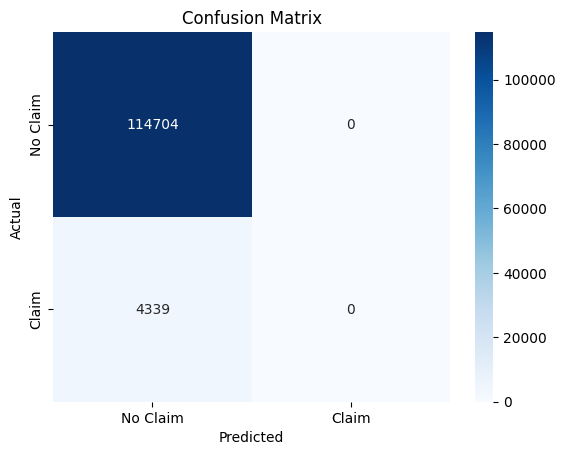

In [39]:
#confusion matrix
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Claim', 'Claim'], yticklabels=['No Claim', 'Claim'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [41]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")



Accuracy: 0.9635509857782482


The accuracy looks fantastic, and matches what we saw with our previous model, but we know that the model is predicting almost 0 (no claim) for everything. This goes along with what we saw on the DummyClassifier with 4% positives - regardless of recalls. 

The model hasn't learned anything meaningful.

Now we can see that the data is very imbalanced. In order to fix this we will have to fit with class_weight.